# **<span style="color:red">Imports</span>**

In [1]:
# Math
import math

# Handy arrays
import numpy as np

# DeepXDE
import deepxde as dde
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


# <span style="color:red">**Постановка**</span>

<div>
<img src="var-07.png" width="600"/>
</div>

# <span style="color:red">**PINN**</span>

## <span style="color:orange">**Init**</span>

### <span>**Функция вычисления невязок**</span>

In [2]:
def pde(domain: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    # d^2 u
    # -----
    # dx ^2
    du_xx = dde.grad.hessian(u, domain, i=0, j=0)

    # d^2 u
    # -----
    # dy ^2
    du_yy = dde.grad.hessian(u, domain, i=1, j=1)

    # du/dt
    du_t = dde.grad.jacobian(u, domain, j=2)

    # Equation
    return ((du_t - 2.3 * (du_xx + du_yy))
            - 2.5586 * torch.exp(-0.7 * domain[:, 2:3]) * torch.sin(0.9 * domain[:, 0:1])
            - 13.5616 * torch.exp(-0.7 * domain[:, 2:3]) * torch.cos(2.2 * domain[:, 1:2]))

### <span>**Геометрия**</span>

In [3]:
# Boundaries
x_left, x_right = 0, math.pi
y_down, y_up = -math.pi, math.pi
T0, T1 = 0, 1

# X & Y geomentry (rectangle)
geometry = dde.geometry.Rectangle(xmin=[x_left, y_down], xmax=[x_right, y_up])
# Time segment [0, 1]
time_domain = dde.geometry.TimeDomain(T0, T1)
# Final domain
domain = dde.geometry.GeometryXTime(geometry, time_domain)

### <span>**Функции принадлежности точки границе**</span>

In [4]:
# Left boundary
def l_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[0], x_left)

In [5]:
# Right boundary
def r_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[0], x_right)

In [6]:
# Up boundary
def up_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[1], y_up)

In [7]:
# Down boundary
def down_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[1], y_down)

In [8]:
# Initial boundary
def initial_boundary(domain, on_initial):
    return on_initial and dde.utils.isclose(domain[2], T0)

### <span>**Граничные и начальные условия**</span>

In [9]:
# Boundary condition left
def bc_l_func(domain):
    if (isinstance(domain, torch.Tensor)):
        t = domain[:, 2:3]
    # Convert to numpy array to CUDA tensor
    else:
        t = torch.from_numpy(domain[:, 2:3]).to(device="cuda")

    return - 1.98 * torch.exp(-0.7 * t)

bc_l = dde.NeumannBC(domain, bc_l_func, l_boundary)

In [10]:
# Boundary condition right
def bc_r_func(domain):
    if (isinstance(domain, torch.Tensor)):
        y = domain[:, 1:2]
        t = domain[:, 2:3]
    # Convert to numpy array to CUDA tensor
    else:
        y = torch.from_numpy(domain[:, 1:2]).to(device="cuda")
        t = torch.from_numpy(domain[:, 2:3]).to(device="cuda")

    return 1.3 + 1.3 * torch.exp(-0.7 * t) * torch.cos(2.2 * y) - 0.55 * (1 - math.sqrt(5)) * torch.exp(-0.7 * t)

bc_r = dde.DirichletBC(domain, bc_r_func, r_boundary)

In [11]:
# Boundary condition up
def bc_up_func(domain):
    if (isinstance(domain, torch.Tensor)):
        t = domain[:, 2:3]
    # Convert to numpy array to CUDA tensor
    else:
        t = torch.from_numpy(domain[:, 2:3]).to(device="cuda")
        
    return - 2.86 * math.sqrt(0.625 - math.sqrt(5)/8) * torch.exp(-0.7 * t)

bc_up = dde.NeumannBC(domain, bc_up_func, up_boundary)

In [12]:
# Boundary condition down
def bc_down_func(domain):
    if (isinstance(domain, torch.Tensor)):
        x = domain[:, 0:1]
        t = domain[:, 2:3]
    # Convert to numpy array to CUDA tensor
    else:
        x = torch.from_numpy(domain[:, 0:1]).to(device="cuda")
        t = torch.from_numpy(domain[:, 2:3]).to(device="cuda")

    return 1.3 + 2.2 * torch.exp(-0.7 * t) * torch.sin(0.9 * x) + 0.875 * (1 + math.sqrt(5)) * torch.exp(-0.7 * t)

bc_down = dde.DirichletBC(domain, bc_down_func, down_boundary)

In [ ]:
# Constant to train
# Initial values: -5.0, 5.0, 8.5
c_lambda = dde.Variable(-5.0)

In [25]:
# Initial condition
def ic_func(domain):
    if (isinstance(domain, torch.Tensor)):
        x = domain[:, 0:1]
        y = domain[:, 1:2]
    # Convert to numpy array to CUDA tensor
    else:
        x = torch.from_numpy(domain[:, 0:1]).to(device="cuda")
        y = torch.from_numpy(domain[:, 1:2]).to(device="cuda")

    return c_lambda + 2.2 * torch.sin(0.9 * x) + 1.3 * torch.cos(2.2 * y)

ic = dde.IC(domain, ic_func, initial_boundary)

In [26]:
# Observed data
data = np.load('var-07.npz')
ob_domain = data['xyt']
ob_u = data['u']
observed_u = dde.icbc.PointSetBC(ob_domain, ob_u, component=0)

### <span>**Система уравнений**</span>

In [27]:
data = dde.data.TimePDE(domain, pde, [bc_l, bc_r, bc_up, bc_down, ic, observed_u],
                        num_domain=3000, num_boundary=1000, num_initial=2000,
                        anchors=ob_domain,
                        num_test=3000)

### <span>**Нейронная сеть**</span>

In [28]:
layer_size = [3] + [50] * 5 + [1]
net = dde.maps.FNN(layer_size, "tanh", "Glorot uniform")

### <span>**Обёртка нейронной сети**</span>

In [29]:
# Init and compile model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, external_trainable_variables=[c_lambda])

Compiling model...
'compile' took 0.000322 s



In [30]:
# Callbacks
variable = dde.callbacks.VariableValue(c_lambda, period=2000)
pde_resampler = dde.callbacks.PDEPointResampler(period=1000)

In [31]:
# Train
losshistory, trainstate = model.train(iterations=20000, callbacks = [pde_resampler, variable])

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [3.06e+01, 1.25e+00, 2.65e+00, 1.02e+00, 1.68e+01, 1.40e+01, 4.25e+00]    [5.27e+01, 1.25e+00, 2.65e+00, 1.02e+00, 1.68e+01, 1.40e+01, 4.25e+00]    []  
0 [-5.00e+00]
1000      [4.77e-01, 4.39e-02, 1.84e-01, 2.60e-02, 2.38e-01, 3.19e-01, 9.70e-02]    [9.37e+00, 4.39e-02, 1.84e-01, 2.60e-02, 2.38e-01, 3.19e-01, 9.70e-02]    []  
2000      [3.74e-01, 3.38e-02, 1.14e-01, 1.16e-02, 1.24e-01, 1.68e-01, 7.85e-02]    [8.08e+00, 3.38e-02, 1.14e-01, 1.16e-02, 1.24e-01, 1.68e-01, 7.85e-02]    []  
2000 [-4.30e+00]
3000      [3.29e-01, 3.05e-02, 9.29e-02, 1.26e-02, 1.39e-01, 6.41e-02, 7.78e-02]    [6.94e+00, 3.05e-02, 9.29e-02, 1.26e-02, 1.39e-01, 6.41e-02, 7.78e-02]    []  
4000      [3.07e-01, 2.24e-02, 6.44e-02, 8.02e-03, 9.07e-02, 6.98e-02, 5.84e-02]    [6.25e+00, 2.24e-02, 6.44e-02, 8.02e-03, 9.0

In [32]:
# Finish training with different optimizer
model.compile("L-BFGS-B")
losshistory, train_state = model.train(callbacks = [pde_resampler, variable])

Compiling model...
'compile' took 0.000608 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
20000     [8.67e-02, 8.25e-03, 4.21e-02, 2.55e-03, 1.64e-02, 1.68e+01, 5.08e-02]    [1.90e+00, 8.25e-03, 4.21e-02, 2.55e-03, 1.64e-02, 1.68e+01, 5.08e-02]    []  
20000 [2.78e+00]

Best model at step 14000:
  train loss: 9.84e-02
  test loss: 3.30e-01
  test metric: []

'train' took 0.042212 s



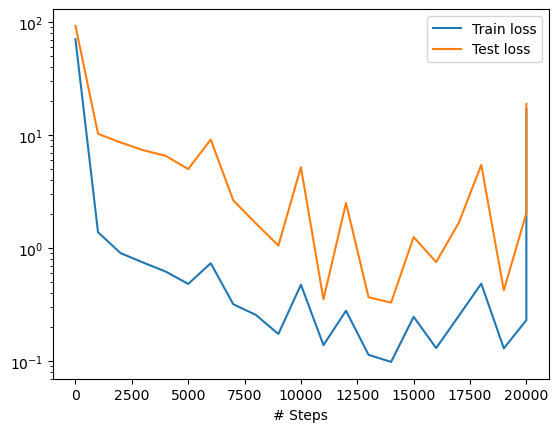

In [33]:
# Save training plot
dde.saveplot(losshistory, trainstate, issave=False, isplot=True)

In [34]:
print(c_lambda)

tensor(2.7791, device='cuda:0', requires_grad=True)
